<a href="https://colab.research.google.com/github/Ehsan1997/ImageSegmentation-UNET-DeepLab-SegNet/blob/master/UNET_ACV_Assg3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!gdown https://drive.google.com/uc?id=16qPeDiPvB9M-UATZohdg1ssCdaIOnf1- 
!unzip MonuSeg.zip

Downloading...
From: https://drive.google.com/uc?id=16qPeDiPvB9M-UATZohdg1ssCdaIOnf1-
To: /content/MonuSeg.zip
96.1MB [00:00, 111MB/s] 
Archive:  MonuSeg.zip
  inflating: MonuSeg/Test/TissueImages/TCGA-GL-6846-01A-01-BS1.tif  
  inflating: MonuSeg/Test/TissueImages/TCGA-AO-A0J2-01A-01-BSA.tif  
  inflating: MonuSeg/Test/TissueImages/TCGA-44-2665-01B-06-BS6.tif  
  inflating: MonuSeg/Training/GroundTruth/TCGA-38-6178-01Z-00-DX1_bin_mask.png  
  inflating: MonuSeg/Training/GroundTruth/TCGA-21-5786-01Z-00-DX1_bin_mask.png  
  inflating: MonuSeg/Test/TissueImages/TCGA-A6-6782-01A-01-BS1.tif  
  inflating: MonuSeg/Training/GroundTruth/TCGA-50-5931-01Z-00-DX1_bin_mask.png  
  inflating: MonuSeg/Training/GroundTruth/TCGA-AR-A1AS-01Z-00-DX1_bin_mask.png  
  inflating: MonuSeg/Test/TissueImages/TCGA-HC-7209-01A-01-TS1.tif  
  inflating: MonuSeg/Test/TissueImages/TCGA-IZ-8196-01A-01-BS1.tif  
  inflating: MonuSeg/Training/GroundTruth/TCGA-CH-5767-01Z-00-DX1_bin_mask.png  
  inflating: MonuSeg/Tr

In [0]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from keras import backend as K

In [0]:
# Set some parameters
im_width = 1024
im_height = 1024
border = 5

In [6]:
ids = next(os.walk("MonuSeg/Training/TissueImages"))[2] # list of names all images in the given path
print("No. of images = ", len(ids))

No. of images =  30


In [0]:
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

#### Load the images and masks into arrays

In [8]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img("MonuSeg/Training/TissueImages/"+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (1024, 1024, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask_id_ = id_.split('.')[0] + '_bin_mask.png'
    mask = img_to_array(load_img("MonuSeg/Training/GroundTruth/"+mask_id_, grayscale=True))
    mask = resize(mask, (1024, 1024, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [0]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

#### Below code can be used to visualize the images and corresponding masks

Text(0.5, 1.0, 'GroundTruth')

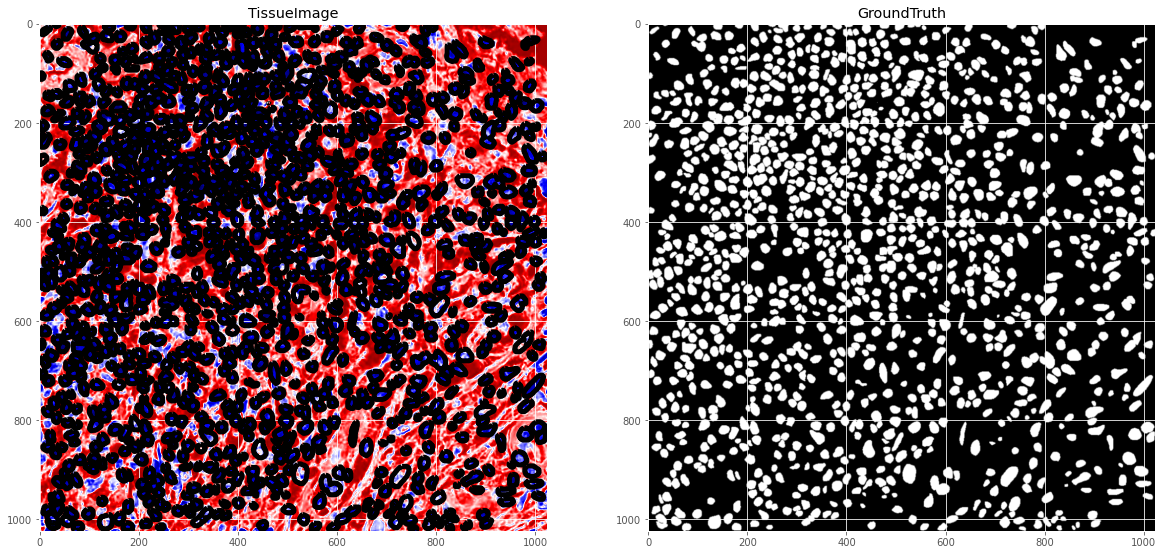

In [10]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'seismic', interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('TissueImage')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('GroundTruth')

In [0]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [0]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [0]:
# Define Some metrics
## Dice Score
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())
## F1 Score
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [0]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy", dice_coef, f1])

In [18]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 1024, 1024, 1 0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 1024, 1024, 1 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 1024, 1024, 1 64          conv2d_21[0][0]                  
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 1024, 1024, 1 0           batch_normalization_20[0][0]     
____________________________________________________________________________________________

In [0]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [22]:
results = model.fit(X_train, y_train, batch_size=1, epochs=8, callbacks=callbacks,
                    validation_data=(X_valid, y_valid))

Train on 27 samples, validate on 3 samples
Epoch 1/8
27/27 [==============================] - 6s 238ms/step - loss: 0.3066 - acc: 0.8399 - dice_coef: 0.6232 - f1: 0.7311 - val_loss: 0.4545 - val_acc: 0.7899 - val_dice_coef: 0.5847 - val_f1: 0.6721

Epoch 00001: val_loss did not improve from 0.30212
Epoch 2/8
27/27 [==============================] - 6s 236ms/step - loss: 0.2942 - acc: 0.8457 - dice_coef: 0.6401 - f1: 0.7420 - val_loss: 0.2751 - val_acc: 0.8534 - val_dice_coef: 0.6470 - val_f1: 0.7252

Epoch 00002: val_loss improved from 0.30212 to 0.27510, saving model to model-tgs-salt.h5
Epoch 3/8
27/27 [==============================] - 6s 236ms/step - loss: 0.2850 - acc: 0.8484 - dice_coef: 0.6507 - f1: 0.7471 - val_loss: 0.2516 - val_acc: 0.8606 - val_dice_coef: 0.6443 - val_f1: 0.7173

Epoch 00003: val_loss improved from 0.27510 to 0.25164, saving model to model-tgs-salt.h5
Epoch 4/8
27/27 [==============================] - 6s 236ms/step - loss: 0.2783 - acc: 0.8510 - dice_coef: 0

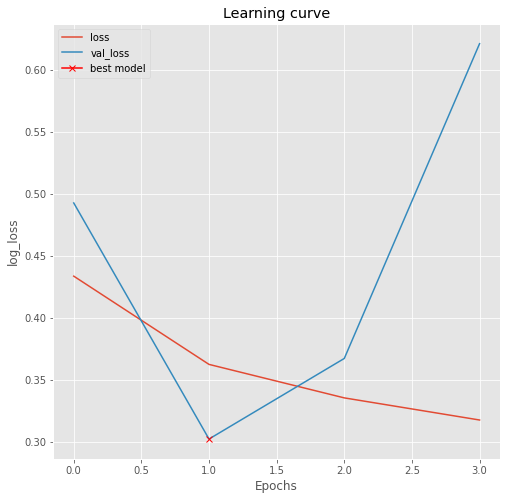

In [21]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();